# Проверка эффективности работы EdgeTPU на тестовом наборе данных

## Импорт библиотек настройка путей

In [21]:
from pycoral.utils import edgetpu
import os
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm

In [13]:
from pycoral.pybind._pywrap_coral import SetVerbosity as set_verbosity
set_verbosity(0)

True

> установка уровня подробности отладки для начального старта платы и подключения драйверов. Также помогает переподключение модуля через usb - разъем и включение/выключение через диспетчер устройств Windows

In [14]:
from ultralytics import YOLO

In [74]:
# Путь к изображениям и меткам
IMAGES_DIR = "HERIDAL.v1i.yolov5pytorch/train/images"
LABELS_DIR = "HERIDAL.v1i.yolov5pytorch/train/labels"
MODEL_PATH = "models/best_9_full_integer_quant_edgetpu.tflite"
MODEL_PATH_CPU = "models/best_9.pt"

## Проверка работы на единичном изображении

In [75]:
# Load the exported TFLite Edge TPU model
edgetpu_model = YOLO(MODEL_PATH_CPU, task='detect')

In [77]:
results = edgetpu_model(os.path.join(IMAGES_DIR, "test_BLI_0001_jpg.rf.561bb278e126161a18c1d99c9ae37d7c.jpg"))


image 1/1 C:\prj\DLS\dls_prj\HERIDAL.v1i.yolov5pytorch\train\images\test_BLI_0001_jpg.rf.561bb278e126161a18c1d99c9ae37d7c.jpg: 640x640 3 items, 76.2ms
Speed: 2.7ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


> Должна быть выведена следующая информация


```
Loading models \best_9_full_integer_quant_edgetpu.tflite on device 0 for TensorFlow Lite Edge TPU inference...

image 1/1 C:\prj\DLS\dls_prj\HERIDAL.v1i.yolov5pytorch\train\images\test_BLI_0001_jpg.rf.561bb278e126161a18c1d99c9ae37d7c.jpg: 640x640 2 items , 67.6ms
Speed: 4.1ms preprocess, 67.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)
```

> Модель загружена и найдено 2 объекта за примерно 60-70 ms

### Получение списка файлов картинок и боксов

In [80]:
# Загрузка модели
model = YOLO(MODEL_PATH_CPU, task='detect')

In [81]:
# Получение списка файлов
image_files = [f for f in os.listdir(IMAGES_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

In [27]:
# Функция для чтения ground truth боксов из YOLOv5 txt
def read_yolo_label(label_path):
    boxes = []
    if not os.path.exists(label_path):
        return boxes
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls, x, y, w, h = map(float, parts[:5])
            boxes.append([cls, x, y, w, h])
    return boxes

### Предсказание и визуализация для одной картинки


image 1/1 C:\prj\DLS\dls_prj\HERIDAL.v1i.yolov5pytorch\train\images\test_BLI_0002_jpg.rf.68ecfe1e92b08d9957b955fa4a186bc4.jpg: 640x640 6 items, 106.3ms
Speed: 5.1ms preprocess, 106.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


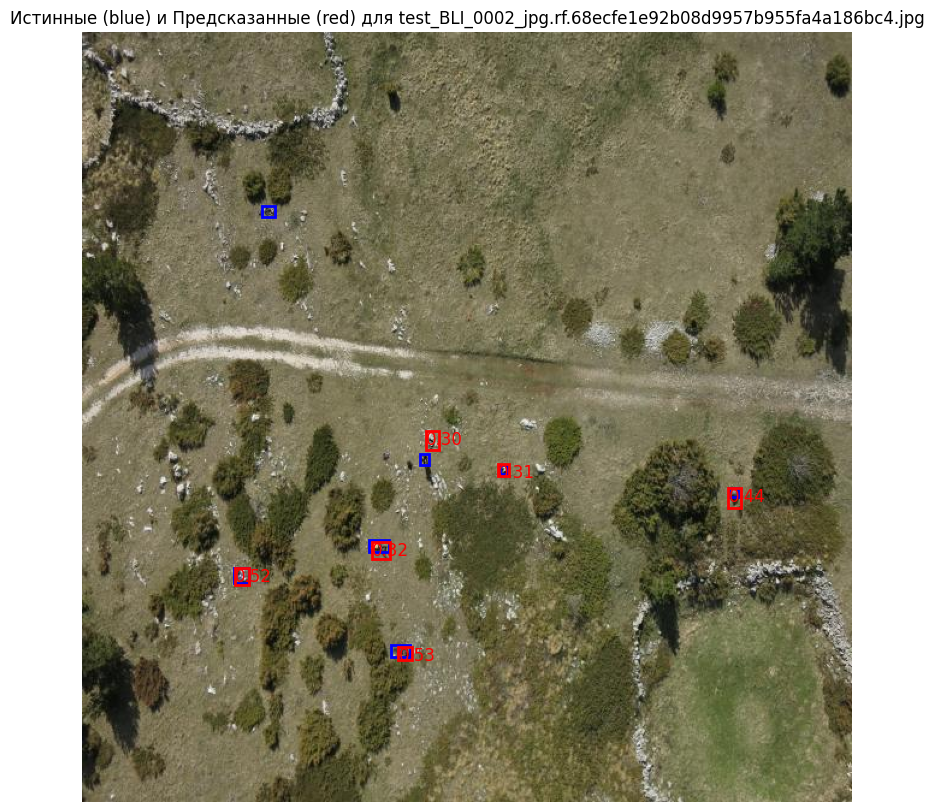

In [82]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Выберите индекс картинки для визуализации
idx = 1  # можно поменять на нужный индекс
img_name = image_files[idx]
img_path = os.path.join(IMAGES_DIR, img_name)
label_name = os.path.splitext(img_name)[0] + ".txt"
label_path = os.path.join(LABELS_DIR, label_name)

# Загрузка изображения
img = Image.open(img_path)
img_w, img_h = img.size

# Загрузка GT боксов
gt_boxes = read_yolo_label(label_path)

# Предсказания модели
results = model(img_path)
preds = results[0].boxes
pred_boxes = []
if preds is not None and len(preds) > 0:
    for i in range(len(preds)):
        cls = preds.cls[i].item()
        conf = preds.conf[i].item()
        x, y, w, h = preds.xywhn[i].tolist()
        pred_boxes.append([cls, conf, x, y, w, h])

# Визуализация
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img)

# GT (синие)
for b in gt_boxes:
    cls, x, y, w, h = b
    x1 = (x - w/2) * img_w
    y1 = (y - h/2) * img_h
    rect = patches.Rectangle((x1, y1), w*img_w, h*img_h, linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)

# Предсказания (красные)
for b in pred_boxes:
    cls, conf, x, y, w, h = b
    x1 = (x - w/2) * img_w
    y1 = (y - h/2) * img_h
    rect = patches.Rectangle((x1, y1), w*img_w, h*img_h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1, f'{conf:.2f}', color='r', fontsize=12, verticalalignment='top')

plt.title(f"Истинные (blue) и Предсказанные (red) для {img_name}")
plt.axis('off')
plt.show()

### Выделение функций и добавление полной диагностической информации

In [50]:
def box_xywhn_to_xyxy(box, img_w, img_h):
    # box: [cls, x, y, w, h] (нормализованные)
    cls, x, y, w, h = box
    x1 = (x - w/2) * img_w
    y1 = (y - h/2) * img_h
    x2 = (x + w/2) * img_w
    y2 = (y + h/2) * img_h
    return [cls, x1, y1, x2, y2]

def iou_xyxy(boxA, boxB):
    # boxA, boxB: [x1, y1, x2, y2]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

In [36]:
idx = 1  # Номер картинки

img_name = image_files[idx]
img_path = os.path.join(IMAGES_DIR, img_name)
label_name = os.path.splitext(img_name)[0] + ".txt"
label_path = os.path.join(LABELS_DIR, label_name)

# Загрузка изображения
img = Image.open(img_path)
img_w, img_h = img.size

# Загрузка GT боксов
gt_boxes = read_yolo_label(label_path)

# Предсказания модели
results = model(img_path)
preds = results[0].boxes
pred_boxes = []
if preds is not None and len(preds) > 0:
    for i in range(len(preds)):
        cls = preds.cls[i].item()
        conf = preds.conf[i].item()
        x, y, w, h = preds.xywhn[i].tolist()
        pred_boxes.append([cls, conf, x, y, w, h])

# Диагностическая информация
print(f"Изображение: {img_name}")
print(f"Истинные боксы: {len(gt_boxes)}")
print(f"Предсказанные боксы: {len(pred_boxes)}")
print("Истинные классы:", [b[0] for b in gt_boxes])
print("Пресказанные классы:", [b[0] for b in pred_boxes])
print("Предсказанные confidences:", [b[1] for b in pred_boxes])
print("Истинные боксы (xywhn):", gt_boxes)
print("Предсказанные (xywhn):", pred_boxes)


image 1/1 C:\prj\DLS\dls_prj\HERIDAL.v1i.yolov5pytorch\train\images\test_BLI_0002_jpg.rf.68ecfe1e92b08d9957b955fa4a186bc4.jpg: 640x640 9 items, 62.6ms
Speed: 3.0ms preprocess, 62.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Изображение: test_BLI_0002_jpg.rf.68ecfe1e92b08d9957b955fa4a186bc4.jpg
Истинные боксы: 7
Предсказанные боксы: 9
Истинные классы: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Пресказанные классы: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Предсказанные confidences: [0.6298300623893738, 0.5000177621841431, 0.46636271476745605, 0.43270766735076904, 0.403860479593277, 0.403860479593277, 0.403860479593277, 0.37020543217658997, 0.3413582742214203]
Истинные боксы (xywhn): [[0.0, 0.384375, 0.6671875, 0.025, 0.015625], [0.0, 0.4125, 0.803125, 0.02421875, 0.015625], [0.0, 0.20546875, 0.7046875, 0.01953125, 0.01953125], [0.0, 0.44375, 0.5546875, 0.0109375, 0.0140625], [0.0, 0.54609375, 0.5671875, 0.01015625, 0.0109375], [0.0, 0.8453125, 0.59765625, 0.0117187

IoU матрица (pred x gt):
 [[          0           0           0           0           0     0.30874           0]
 [          0           0           0           0           0           0           0]
 [          0           0     0.62658           0           0           0           0]
 [          0           0           0           0           0           0           0]
 [          0           0           0           0           0           0           0]
 [          0           0           0           0           0     0.39607           0]
 [          0     0.31703           0           0           0           0           0]
 [          0           0           0           0     0.59342           0           0]
 [    0.47271           0           0           0           0           0           0]]
TP: 2, FP: 7, FN: 5
Precision: 0.222, Recall: 0.286


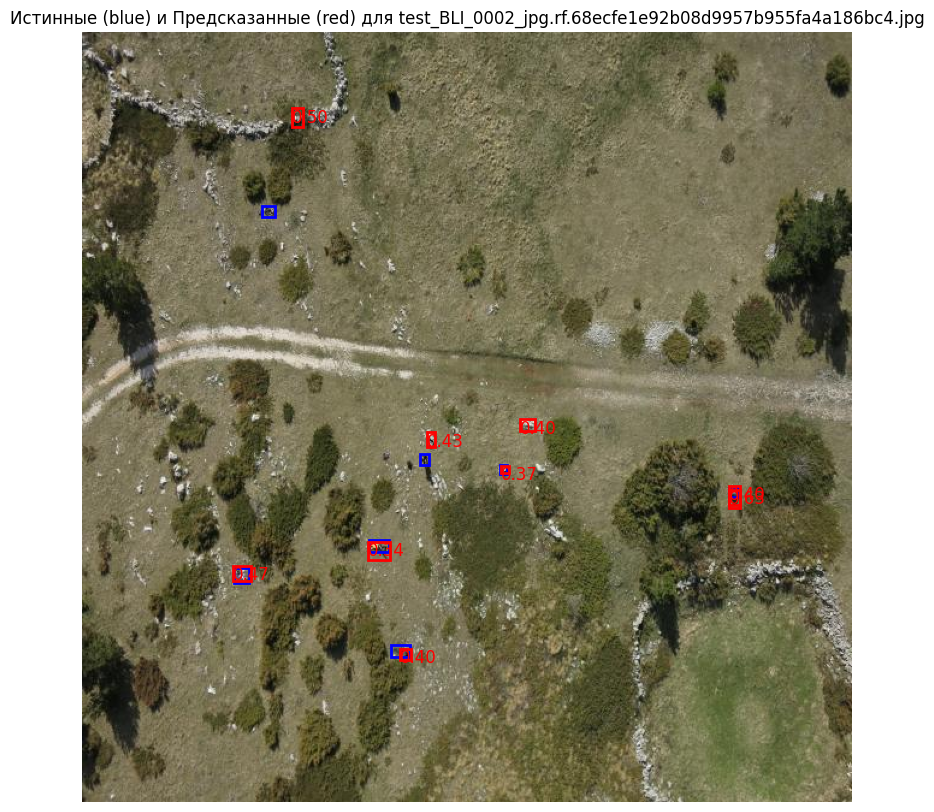

In [37]:
# Переводим в xyxy для IoU
gt_xyxy = [box_xywhn_to_xyxy(b, img_w, img_h)[1:] for b in gt_boxes]
pred_xyxy = [box_xywhn_to_xyxy([b[0], b[2], b[3], b[4], b[5]], img_w, img_h)[1:] for b in pred_boxes]

# Расчет IoU для каждой пары pred-GT
ious = np.zeros((len(pred_boxes), len(gt_boxes)))
for i, pb in enumerate(pred_xyxy):
    for j, gb in enumerate(gt_xyxy):
        ious[i, j] = iou_xyxy(pb, gb)
print("IoU матрица (pred x gt):\n", ious)

# Простая метрика: TP если IoU > 0.5 и класс совпадает
TP = 0
FP = 0
FN = 0
matched_gt = set()
for i, b in enumerate(pred_boxes):
    found = False
    for j, gb in enumerate(gt_boxes):
        if gb[0] == b[0] and ious[i, j] > 0.5 and j not in matched_gt:
            TP += 1
            matched_gt.add(j)
            found = True
            break
    if not found:
        FP += 1
FN = len(gt_boxes) - len(matched_gt)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
print(f"TP: {TP}, FP: {FP}, FN: {FN}")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}")

# Визуализация
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img)

# Истинные (синие)
for b in gt_boxes:
    cls, x, y, w, h = b
    x1 = (x - w/2) * img_w
    y1 = (y - h/2) * img_h
    rect = patches.Rectangle((x1, y1), w*img_w, h*img_h, linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)

# Предсказания (красные)
for b in pred_boxes:
    cls, conf, x, y, w, h = b
    x1 = (x - w/2) * img_w
    y1 = (y - h/2) * img_h
    rect = patches.Rectangle((x1, y1), w*img_w, h*img_h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1, f'{conf:.2f}', color='r', fontsize=12, verticalalignment='top')

plt.title(f"Истинные (blue) и Предсказанные (red) для {img_name}")
plt.axis('off')
plt.show()

## Предсказание и сбор статистики по всему набору данных

In [51]:
# image_files = image_files[:10]

In [83]:
# --- Сбор предсказаний и GT по всем картинкам ---
prediction_data = []
for img_name in image_files:
    img_path = os.path.join(IMAGES_DIR, img_name)
    label_name = os.path.splitext(img_name)[0] + ".txt"
    label_path = os.path.join(LABELS_DIR, label_name)

    # Загрузка GT боксов
    gt_boxes = read_yolo_label(label_path)

    # Предсказания модели
    results = model(img_path)
    preds = results[0].boxes
    pred_boxes = []
    if preds is not None and len(preds) > 0:
        for i in range(len(preds)):
            cls = preds.cls[i].item()
            conf = preds.conf[i].item()
            x, y, w, h = preds.xywhn[i].tolist()
            pred_boxes.append([cls, conf, x, y, w, h])

    prediction_data.append({
        'filename': img_name,
        'pred_boxes': pred_boxes,  # [cls, conf, x, y, w, h]
        'gt_boxes': gt_boxes,       # [cls, x, y, w, h]
        'speed': results[0].speed,
    })

# Теперь prediction_data содержит все предсказания и GT для дальнейшего анализа и расчета метрик


image 1/1 C:\prj\DLS\dls_prj\HERIDAL.v1i.yolov5pytorch\train\images\test_BLI_0001_jpg.rf.561bb278e126161a18c1d99c9ae37d7c.jpg: 640x640 3 items, 60.9ms
Speed: 3.5ms preprocess, 60.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\prj\DLS\dls_prj\HERIDAL.v1i.yolov5pytorch\train\images\test_BLI_0002_jpg.rf.68ecfe1e92b08d9957b955fa4a186bc4.jpg: 640x640 6 items, 87.7ms
Speed: 3.4ms preprocess, 87.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\prj\DLS\dls_prj\HERIDAL.v1i.yolov5pytorch\train\images\test_BLI_0003_jpg.rf.7e0df026edecf9c29ab998a66fa8ac7a.jpg: 640x640 3 items, 91.8ms
Speed: 4.9ms preprocess, 91.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\prj\DLS\dls_prj\HERIDAL.v1i.yolov5pytorch\train\images\test_BLI_0004_jpg.rf.61f9e0af0aa9ea3f849dc4d17fc0cd13.jpg: 640x640 10 items, 84.4ms
Speed: 5.2ms preprocess, 84.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

im

In [84]:
prediction_data[0]

{'filename': 'test_BLI_0001_jpg.rf.561bb278e126161a18c1d99c9ae37d7c.jpg',
 'pred_boxes': [[0.0,
   0.44574594497680664,
   0.5047365427017212,
   0.18433645367622375,
   0.020467186346650124,
   0.018393754959106445],
  [0.0,
   0.2918553054332733,
   0.6742274165153503,
   0.18615826964378357,
   0.023735810071229935,
   0.02437000349164009],
  [0.0,
   0.26507270336151123,
   0.42762795090675354,
   0.26686936616897583,
   0.014504432678222656,
   0.025220204144716263]],
 'gt_boxes': [[0.0, 0.67421875, 0.1859375, 0.0265625, 0.025],
  [0.0, 0.50390625, 0.18203125, 0.0203125, 0.01484375],
  [0.0, 0.42578125, 0.26171875, 0.0109375, 0.0140625],
  [0.0, 0.83125, 0.48984375, 0.0171875, 0.0171875],
  [0.0, 0.28046875, 0.44453125, 0.01640625, 0.01328125]],
 'speed': {'preprocess': 3.5418999977991916,
  'inference': 60.88199999794597,
  'postprocess': 1.0269999984302558}}

### Функции для обработки статистики

In [42]:
import numpy as np

def calc_metrics_for_prediction(prediction, img_w, img_h, iou_threshold=0.5):
    """
    prediction: элемент из prediction_data
    img_w, img_h: размеры изображения
    iou_threshold: порог для TP
    Возвращает: TP, FP, FN, precision, recall
    """
    pred_boxes = prediction['pred_boxes']  # [cls, conf, x, y, w, h]
    gt_boxes = prediction['gt_boxes']      # [cls, x, y, w, h]

    # Переводим в xyxy
    pred_xyxy = [box_xywhn_to_xyxy([b[0], b[2], b[3], b[4], b[5]], img_w, img_h)[1:] for b in pred_boxes]
    gt_xyxy = [box_xywhn_to_xyxy(b, img_w, img_h)[1:] for b in gt_boxes]

    TP = 0
    FP = 0
    FN = 0
    matched_gt = set()
    for i, pb in enumerate(pred_xyxy):
        found = False
        for j, gb in enumerate(gt_xyxy):
            if j in matched_gt:
                continue
            iou = iou_xyxy(pb, gb)
            if iou > iou_threshold:
                TP += 1
                matched_gt.add(j)
                found = True
                break
        if not found:
            FP += 1
    FN = len(gt_boxes) - len(matched_gt)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return TP, FP, FN, precision, recall

### Пример обработки статистики для одной картинки

In [43]:
# Номер изображения:
idx = 3

img_name = prediction_data[idx]['filename']
img_path = os.path.join(IMAGES_DIR, img_name)
from PIL import Image
img = Image.open(img_path)
img_w, img_h = img.size

TP, FP, FN, precision, recall = calc_metrics_for_prediction(prediction_data[idx], img_w, img_h)
print(f"TP: {TP}, FP: {FP}, FN: {FN}, Precision: {precision:.3f}, Recall: {recall:.3f}")

TP: 5, FP: 5, FN: 13, Precision: 0.500, Recall: 0.278


### Функции для вычисления интегральных метрик

In [53]:
def calc_integral_metrics(prediction_data, images_dir, iou_threshold=0.5):
    """
    Считает интегральные метрики по всему prediction_data.
    Использует calc_metrics_for_prediction для каждого изображения.
    Возвращает: TP, FP, FN, precision, recall, F1
    """
    from PIL import Image

    total_TP = 0
    total_FP = 0
    total_FN = 0

    for pred in prediction_data:
        img_name = pred['filename']
        img_path = os.path.join(images_dir, img_name)
        img = Image.open(img_path)
        img_w, img_h = img.size

        TP, FP, FN, _, _ = calc_metrics_for_prediction(pred, img_w, img_h, iou_threshold)
        total_TP += TP
        total_FP += FP
        total_FN += FN

    precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
    recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return total_TP, total_FP, total_FN, precision, recall, f1

In [55]:
def compute_ap(recall, precision):
    """
    Вычисляет AP (area under PR curve) по точкам recall и precision.
    """
    # Добавляем крайние точки
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # Делаем precision неубывающим справа налево
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # Находим точки, где recall меняется
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    # Считаем площадь под кривой
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return ap

In [56]:
def gather_all_predictions(prediction_data, images_dir, iou_threshold=0.5):
    """
    Собирает все предсказания и GT в списки для расчета PR-curve.
    Возвращает: pred_confs, pred_matches, num_gt
    """
    from PIL import Image
    pred_confs = []
    pred_matches = []
    num_gt = 0

    for pred in prediction_data:
        img_name = pred['filename']
        img_path = os.path.join(images_dir, img_name)
        img = Image.open(img_path)
        img_w, img_h = img.size

        pred_boxes = pred['pred_boxes']
        gt_boxes = pred['gt_boxes']
        num_gt += len(gt_boxes)

        # Переводим в xyxy
        pred_xyxy = [box_xywhn_to_xyxy([b[0], b[2], b[3], b[4], b[5]], img_w, img_h)[1:] for b in pred_boxes]
        gt_xyxy = [box_xywhn_to_xyxy(b, img_w, img_h)[1:] for b in gt_boxes]

        matched_gt = set()
        # Сортируем предсказания по confidence (по убыванию)
        pred_with_conf = sorted(zip(pred_boxes, pred_xyxy), key=lambda x: x[0][1], reverse=True)
        for pb, pb_xyxy in pred_with_conf:
            found = False
            for j, gb_xyxy in enumerate(gt_xyxy):
                if j in matched_gt:
                    continue
                iou = iou_xyxy(pb_xyxy, gb_xyxy)
                if iou > iou_threshold:
                    pred_matches.append(1)  # TP
                    matched_gt.add(j)
                    found = True
                    break
            if not found:
                pred_matches.append(0)  # FP
            pred_confs.append(pb[1])
    return np.array(pred_confs), np.array(pred_matches), num_gt

In [57]:
def calc_map50(prediction_data, images_dir, iou_threshold=0.5):
    """
    Считает mAP@0.5 по всему prediction_data (один класс).
    """
    pred_confs, pred_matches, num_gt = gather_all_predictions(prediction_data, images_dir, iou_threshold)
    if len(pred_confs) == 0 or num_gt == 0:
        return 0.0

    # Сортируем по confidence
    idxs = np.argsort(-pred_confs)
    pred_matches = pred_matches[idxs]

    tp_cum = np.cumsum(pred_matches)
    fp_cum = np.cumsum(1 - pred_matches)
    recall = tp_cum / (num_gt + 1e-16)
    precision = tp_cum / (tp_cum + fp_cum + 1e-16)

    ap = compute_ap(recall, precision)
    return ap

### Расчет основных метрик для набора

In [85]:
TP, FP, FN, precision, recall, f1 = calc_integral_metrics(prediction_data, IMAGES_DIR)
print(f"Total TP: {TP}, FP: {FP}, FN: {FN}")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
mAP50 = calc_map50(prediction_data, IMAGES_DIR)
print(f"mAP@0.5: {mAP50:.3f}")

Total TP: 1100, FP: 868, FN: 1978
Precision: 0.559, Recall: 0.357, F1: 0.436
mAP@0.5: 0.262


### Расчет производительности

In [86]:
# Собираем все значения 'inference' из 'speed' для каждого элемента prediction_data
speeds = np.array([item['speed']['inference'] for item in prediction_data])

In [87]:
mean_speed = np.mean(speeds)
min_speed = np.min(speeds)
max_speed = np.max(speeds)

print("Среднее:", mean_speed)
print("Минимальное:", min_speed)
print("Максимальное:", max_speed)

Среднее: 82.88932659908053
Минимальное: 59.72409999958472
Максимальное: 1358.6545000034675


## Прогон для моделей CPU и TPU

### TPU

Total TP: 679, FP: 1645, FN: 2399

Precision: 0.292, Recall: 0.221, F1: 0.251

mAP@0.5: 0.106

Скорость вывода

Среднее: 67

Минимальное: 59

Максимальное: 112

### CPU

Total TP: 1100, FP: 868, FN: 1978

Precision: 0.559, Recall: 0.357, F1: 0.436

mAP@0.5: 0.262

Скорость вывода

Среднее: 82

Минимальное: 59

Максимальное: 1358